# Data Load

In [1]:
# data load
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_0 = x_train[y_train == 0]
n_row, n_xaxis, n_yaxis = x_train_0.shape
x_train_0 = x_train_0.reshape(len(x_train_0), n_xaxis * n_yaxis)
print(x_train_0.shape)

(5923, 784)


# PCA
* 모든 주성분을 보기 위해 mnist의 전체 크기인 784로 주성분 분석 실행
* 0번, 100번, ..., 700번의 주성분 출력
* 약 50번째 성분에서 곡선이 완만해지고 400번째에서 거의 0에 가까워짐. 따라서 400개의 주성분으로 대부분의 데이터를 표현할 수 있다고 해석할 수 있음

(5923, 784)
           0        100      200      300      400      500     600     700
count  5923.00  5923.00  5923.00  5923.00  5923.00  5923.00  5923.0  5923.0
mean     -0.00     0.00     0.00     0.00     0.00     0.00    -0.0     0.0
std     753.16    47.68    26.04    17.49     8.97     1.19     0.0     0.0
min   -1583.95  -185.33  -107.16   -71.00   -66.84   -21.84    -0.0    -0.0
25%    -642.31   -29.87   -16.86   -11.02    -3.35    -0.24    -0.0    -0.0
50%     -15.17    -0.57    -0.09    -0.28     0.07     0.00    -0.0     0.0
75%     643.27    31.05    16.79    11.42     3.52     0.25     0.0     0.0
max    1657.48   192.24   123.52    93.16    84.39    30.06     0.0     0.0


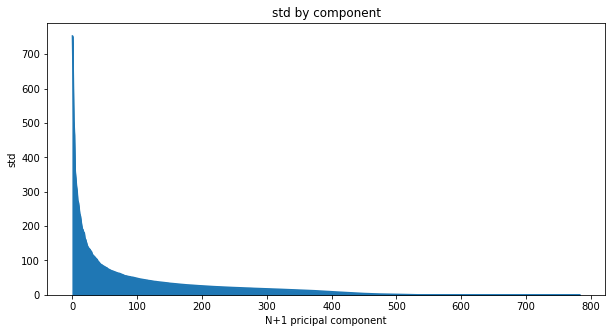

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=784)
x_train_PCA = pca.fit_transform(x_train_0)
print(x_train_PCA.shape)
print_cols = [0, 100, 200, 300, 400, 500, 600, 700]
x_train_PCA = pd.DataFrame(x_train_PCA)
print(x_train_PCA.describe().round(2).loc[:, print_cols])

plt.figure(figsize=(10, 5))
x_train_PCA.describe().loc['std'].plot(kind='area')
plt.title('std by component')
plt.ylabel('std')
plt.xlabel('N+1 pricipal component')
plt.show()

In [5]:
pca.explained_variance_[:10]  # 정보량 판단의 기준이 되는 분산값

explvar_raw = np.sum(np.var(x_train_0, axis=0))  # 로우 데이터의 분산 합
explvar_pca = np.sum(pca.explained_variance_)  # pca 데이터의 분산 합
explvar_error = ((explvar_pca/explvar_raw)-1)*100
explvar_ratio = np.round(1 - explvar_error/100, 3)

if explvar_ratio == 1:  # 오차율이 매우 작으면 일치
    explvar_match = "일치"
else:
    explvar_match = "불일치"

print("로우 데이터의 분산 : %i" % explvar_raw)
print("주성분 분석 후의 분산 : %i" % explvar_pca)
print("오차는 약 %.2f%%이고, 두 값은 %s한다고 볼 수 있음" % (explvar_error, explvar_match))

로우 데이터의 분산 : 3245975
주성분 분석 후의 분산 : 3246523
오차는 약 0.02%이고, 두 값은 일치한다고 볼 수 있음


In [13]:
explvar_pct = np.sum(pca.explained_variance_ratio_[:10]) * 100  # 상위 주성분 10개의 비율 합
print("주성분 10개가 설명하는 분산의 비율은 전체의 %i%%" % explvar_pct)


주성분 10개가 설명하는 분산의 비율은 전체의 62%


In [17]:
# mnist visualize
def plot_mnist(data, p_row, p_col, size, title=False):
    fig, axis = plt.subplots(p_row, p_col,
                            figsize=(p_col*size, p_row*size),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axis.flat):
        ax.imshow(data[i], cmap='gray')
    if title:
        fig.suptitle(title)

# Eigenvector visualizing
* 상위에 위치한 성분일수록 데이터를 잘 표현하고, 하위로 갈수록 공통 정보를 제외한 여분의 정보들이 표현됨
* 상위 성분들이 데이터의 특성을 반영하는 주요 정보임을 의미

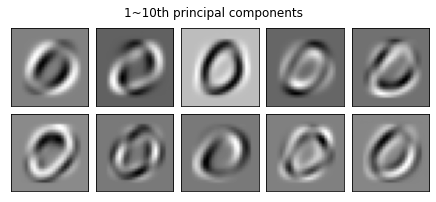

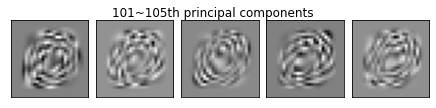

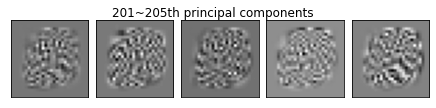

In [19]:
plt_data = pca.components_.reshape(len(pca.components_), n_xaxis, n_xaxis)
plot_mnist(plt_data, 2, 5, 1.5, '1~10th principal components')
plot_mnist(plt_data[100:], 1, 5, 1.5, '101~105th principal components')
plot_mnist(plt_data[200:], 1, 5, 1.5, '201~205th principal components')
plt.show()

# PCA Denoise
* PCA는 공통적인 성분을 먼저 뽑는 성질을 이용하여 노이즈 제거
* 노이즈는 랜덤한 값에 속하기 때문에 상관계수가 0에 가깝게 나옴. 따라서 하나의 변수가 하나의 성분이 되기 때문에 낮은 정보량을 가지는 성분으로 분류됨

In [20]:
def add_uniform_noise(df, noise_pct=0.1):
    min_df = np.min(df)
    max_df = np.max(df)
    high_df = ((max_df-min_df) * noise_pct) + min_df
    return df+np.random.uniform(low=min_df, high=high_df, size=df.shape)

x_train_noise = add_uniform_noise(x_train, 0.4)
x_test_noise = add_uniform_noise(x_test, 0.4)

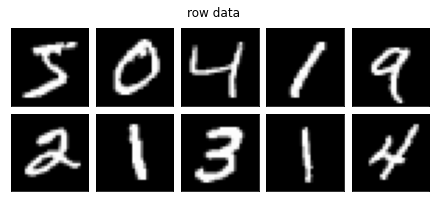

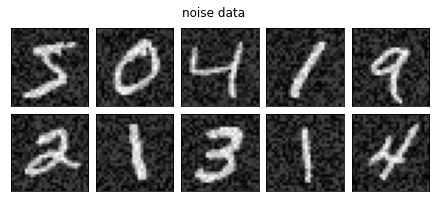

In [21]:
plot_mnist(x_train, 2, 5, 1.5, "row data")
plt.show()
plot_mnist(x_train_noise, 2, 5, 1.5, "noise data")
plt.show()

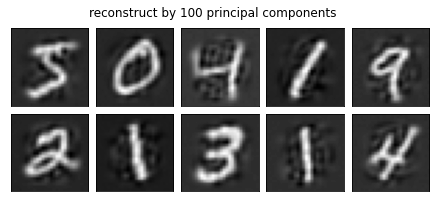

In [24]:
pca = PCA(n_components=100)
n_row, n_xaxis, n_yaxis = x_train_noise.shape
x_train_noise_PCA = pca.fit_transform(x_train_noise.reshape(n_row, n_xaxis*n_yaxis))
x_train_noise_PCA_inv = pca.inverse_transform(x_train_noise_PCA)
x_train_noise_PCA_inv = x_train_noise_PCA_inv.reshape(n_row, n_xaxis, n_yaxis)

plot_mnist(x_train_noise_PCA_inv, 2, 5, 1.5, "reconstruct by 100 principal components")
plt.show()

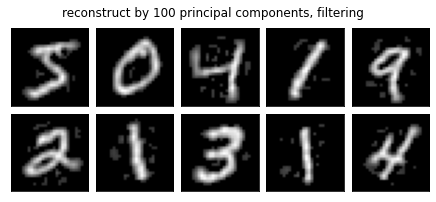

In [25]:
filtering = x_train_noise_PCA_inv * (x_train_noise_PCA_inv > 70)  # 픽셀값이 70 이상인 경우만 남도록 필터링
plot_mnist(filtering, 2, 5, 1.5, 'reconstruct by 100 principal components, filtering')

# Recontruction Error for Dimention Reduction Evaluation
* 데이터 복원 후 로우 데이터와의 오차
* 감소한 분산 비율, 평균 제곱 합, 유사도 등 다양한 방법이 있음

In [26]:
from sklearn import preprocessing as pp

np.random.seed(314)

n_row, n_xaxis, n_yaxis = x_train.shape
n_col = n_xaxis * n_yaxis
n_row_t = x_test.shape[0]

x_train_2d = x_train.reshape(n_row, n_col)
x_test_2d = x_test.reshape(n_row_t, n_col)

scaler = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
scaler = scaler.fit(x_train_2d)

x_train_2d = scaler.transform(x_train_2d)
x_test_2d = scaler.transform(x_test_2d)

In [27]:
pca = PCA(n_components=100)

x_train_2d_PCA = pca.fit_transform(x_train_2d)
x_train_2d_PCA_inv = pca.inverse_transform(x_train_2d_PCA)

x_test_2d_PCA = pca.transform(x_test_2d)
x_test_2d_PCA_inv = pca.inverse_transform(x_test_2d_PCA)

In [28]:
# 재구축된 데이터를 바탕으로 설명된 분산 비율을 계산
def DR_explained_var_ratio(np_recon, raw_var):
    return np.var(np_recon, axis=0).sum() / raw_var

In [30]:
var_train = np.var(x_train_2d, axis=0).sum()
var_test = np.var(x_test_2d, axis=0).sum()
evr_pca = [DR_explained_var_ratio(x_train_2d_PCA_inv, var_train),
           DR_explained_var_ratio(x_test_2d_PCA_inv, var_test)]
print("explained var ratio")
print("train : %.3f%%" % (evr_pca[0]*100))
print("test : %.3f%%" % (evr_pca[1]*100))

explained var ratio
train : 70.313%
test : 67.532%


In [31]:
# 로우 데이터와 재구축된 데이터의 MSE 계산
def recon_mse(np_raw, np_recon):
    n_row, n_col = np_raw.shape
    diff_ = np_raw - np_recon
    diff_ = (diff_**2).sum(axis=1) / n_col
    diff_mse = diff_.sum() / n_row
    return diff_mse

In [32]:
recon_mse_pca = [recon_mse(x_train_2d, x_train_2d_PCA_inv),
                 recon_mse(x_test_2d, x_test_2d_PCA_inv)]

print("train MSE : %.5f" % recon_mse_pca[0])
print("test MSE : %.5f" % recon_mse_pca[1])

train MSE : 0.27150
test MSE : 0.29733
